<a href="https://colab.research.google.com/github/abyanjan/Model-Explanation-with-SHAP/blob/master/Model_Explanation_with_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Explaning Machine Learning Models with SHAP

In [1]:
!pip install -q shap

     |████████████████████████████████| 358kB 5.4MB/s 


In [2]:
!pip install -q feature_engine

     |████████████████████████████████| 153kB 6.6MB/s 
     |████████████████████████████████| 9.5MB 8.6MB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

### Data

The data used here is the data from Lending club credit data. It has been preprocessed with data cleaning and feature selection.  
We will apply XGBoost model to classify loans as default or good loans.

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Lendingclub_data_preparation/xgboost/Latest/Data/train_df.csv')

In [5]:
data.head()

,int_rate,term,acc_open_past_24mths,dti,funded_amnt_inv,avg_cur_bal,emp_length,fico_score,home_ownership,grade,mort_acc,revol_util,revol_bal,annual_inc,mths_since_recent_inq,year_from_earliest_cr_line,delinq_2yrs,loan_status
0,14.31,36 months,12,18.16,10000.0,32098,< 1 year,702.0,MORTGAGE,C,4,42.6,20874,70000.0,15.0,10.168587,0,1
1,16.55,36 months,3,30.24,2000.0,8525,10+ years,682.0,MORTGAGE,D,0,93.8,26548,60000.0,0.0,13.580019,0,0
2,19.19,36 months,6,10.71,33600.0,12111,9 years,677.0,MORTGAGE,E,4,63.3,16330,80000.0,6.0,14.417818,more_than_1,1
3,10.49,36 months,2,4.80,8000.0,799,10+ years,672.0,MORTGAGE,B,0,31.2,6388,48000.0,21.0,9.837300,1,0
4,10.99,60 months,0,6.90,20000.0,92608,10+ years,687.0,MORTGAGE,B,1,87.7,16931,143000.0,NaN,37.418975,1,1


In [6]:
data.shape

(266146, 18)

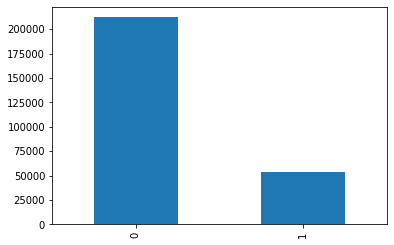

In [7]:
# distribution of target feature -'loan_status'
data.loan_status.value_counts().plot(kind='bar');

Here, 1 is the positive class that is being default and 0 is the negative class that states a good loan.

In [8]:
# Missing values
data.isnull().sum()

int_rate                          0
term                              0
acc_open_past_24mths              0
dti                               0
funded_amnt_inv                   0
avg_cur_bal                       0
emp_length                    14816
fico_score                        0
home_ownership                    0
grade                             0
mort_acc                          0
revol_util                      112
revol_bal                         0
annual_inc                        0
mths_since_recent_inq         27292
year_from_earliest_cr_line        0
delinq_2yrs                       0
loan_status                       0
dtype: int64

We see for three features we have missing values. 
- revl_util has a low number of missing value, so we will simply drop the samples that have missing data. 
- For other two feature we will replace the missing values later

In [9]:
data = data.dropna(subset = ['revol_util'])

In [10]:
data.isnull().sum()

int_rate                          0
term                              0
acc_open_past_24mths              0
dti                               0
funded_amnt_inv                   0
avg_cur_bal                       0
emp_length                    14814
fico_score                        0
home_ownership                    0
grade                             0
mort_acc                          0
revol_util                        0
revol_bal                         0
annual_inc                        0
mths_since_recent_inq         27257
year_from_earliest_cr_line        0
delinq_2yrs                       0
loan_status                       0
dtype: int64

In [11]:
data.shape

(266034, 18)

### Data Processing

**Creating train and test split**

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('loan_status', axis = 1), 
                                                    data.loan_status, 
                                                    stratify = data.loan_status,
                                                    test_size = 0.3, 
                                                    random_state = 1)

We will make a copy of the X_train and X_test, so that we can later use them for displaying while using shap plots.

In [14]:
X_train_display = X_train.copy()
X_test_display = X_test.copy()

In [15]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(186223, 17) (186223,)
(79811, 17) (79811,)


In [16]:
X_train.dtypes

int_rate                      float64
term                           object
acc_open_past_24mths            int64
dti                           float64
funded_amnt_inv               float64
avg_cur_bal                     int64
emp_length                     object
fico_score                    float64
home_ownership                 object
grade                          object
mort_acc                        int64
revol_util                    float64
revol_bal                       int64
annual_inc                    float64
mths_since_recent_inq         float64
year_from_earliest_cr_line    float64
delinq_2yrs                    object
dtype: object

We will encode the categorical features with integers for the modeling, as xgboost can handle categorical features and do not require one hot encoding.

In [17]:
cat_cols = X_train.select_dtypes(include='object').columns.tolist()

In [18]:
cat_cols

['term', 'emp_length', 'home_ownership', 'grade', 'delinq_2yrs']

In [19]:
#checking for missing values
X_train.isnull().sum()

int_rate                          0
term                              0
acc_open_past_24mths              0
dti                               0
funded_amnt_inv                   0
avg_cur_bal                       0
emp_length                    10286
fico_score                        0
home_ownership                    0
grade                             0
mort_acc                          0
revol_util                        0
revol_bal                         0
annual_inc                        0
mths_since_recent_inq         19077
year_from_earliest_cr_line        0
delinq_2yrs                       0
dtype: int64

As mentioned above we will replace the missing values for the two features.
- emp_length is categorical feature and here for simplicity we will replace the missing values with the most occuring category
- mths_since_recent_inq is numerical and again for simpicity we will replace the missing values with median

In [20]:
# creating a pipeline to convert categorical features to integers and handling missing values
from sklearn.pipeline import Pipeline
from feature_engine.encoding import OrdinalEncoder  
#from feature_engine.imputation import DropMissingData
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer

In [21]:
pipeline = Pipeline([('cat_impute', CategoricalImputer(imputation_method='frequent', variables=['emp_length'])),
                     ('num_impute', MeanMedianImputer(imputation_method='median', variables=['mths_since_recent_inq'])),
                     ('cat_encoder', OrdinalEncoder(variables=cat_cols))])

In [22]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('cat_impute',
                 CategoricalImputer(fill_value='Missing',
                                    imputation_method='frequent',
                                    return_object=False,
                                    variables=['emp_length'])),
                ('num_impute',
                 MeanMedianImputer(imputation_method='median',
                                   variables=['mths_since_recent_inq'])),
                ('cat_encoder',
                 OrdinalEncoder(encoding_method='ordered',
                                variables=['term', 'emp_length',
                                           'home_ownership', 'grade',
                                           'delinq_2yrs']))],
         verbose=False)

In [23]:
# transform train and test data with the pipeline
X_train = pipeline.transform(X_train)
X_test = pipeline.transform(X_test)

In [24]:
X_train.head()

,int_rate,term,acc_open_past_24mths,dti,funded_amnt_inv,avg_cur_bal,emp_length,fico_score,home_ownership,grade,mort_acc,revol_util,revol_bal,annual_inc,mths_since_recent_inq,year_from_earliest_cr_line,delinq_2yrs
82713,9.17,0,3,3.50,5000.0,1157,5,667.0,2,1,0,49.5,5786,60000.0,11.0,21.747195,2
151955,9.99,0,4,10.16,10000.0,1636,3,677.0,1,1,1,67.7,10833,46000.0,17.0,30.837047,0
59514,18.55,1,6,14.61,34200.0,30557,4,677.0,0,4,6,58.8,39313,82000.0,1.0,41.000157,1
184409,11.53,0,6,13.85,12000.0,2167,1,722.0,2,1,0,73.1,21563,100000.0,21.0,13.998919,0
165135,19.19,1,7,19.49,28000.0,4600,6,672.0,2,4,0,68.0,20959,105000.0,4.0,10.250724,0


In [25]:
X_train.isnull().sum()

int_rate                      0
term                          0
acc_open_past_24mths          0
dti                           0
funded_amnt_inv               0
avg_cur_bal                   0
emp_length                    0
fico_score                    0
home_ownership                0
grade                         0
mort_acc                      0
revol_util                    0
revol_bal                     0
annual_inc                    0
mths_since_recent_inq         0
year_from_earliest_cr_line    0
delinq_2yrs                   0
dtype: int64

In [26]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(186223, 17) (186223,)
(79811, 17) (79811,)


### Modeling with Xgboost

In [27]:
import xgboost
from xgboost import XGBClassifier

In [28]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [29]:
# make predictions
pred = xgb.predict_proba(X_test)

In [30]:
# AUC score
from sklearn.metrics import roc_auc_score, classification_report

print('AUC')
roc_auc_score(y_test, pred[:,1])

AUC


0.7322817142627096

### Model Explanation with SHAP

In [32]:
# create the explainer and get shap values for test data
explainer = shap.TreeExplainer(xgb, data= X_train,  model_output="probability")
shap_values = explainer.shap_values(X_test)

 99%|===================| 79406/79811 [02:02<00:00]       

Using the shap explainer on the test data, it provides shap values for each samples with respect to the features.

In [33]:
shap_values.shape

(79811, 17)

In [34]:
pd.DataFrame(shap_values).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.074318,-0.018007,0.021168,-0.005531,-0.000121,-0.000743,0.000230,0.010843,-0.007105,0.002540,0.003285,-0.000495,-0.000659,0.000371,-0.001877,0.000328,-0.000388
1,-0.026393,0.050748,-0.011737,-0.020620,0.004774,-0.016655,0.000171,-0.001704,-0.009590,0.003179,-0.004305,-0.000265,-0.005106,-0.008890,-0.002196,0.002219,-0.000510
2,0.046050,0.078600,-0.027482,0.019605,0.008705,-0.021774,-0.002243,-0.015317,-0.011904,0.002173,0.003910,0.006303,-0.013305,-0.004750,0.006833,-0.000692,-0.000575
3,-0.005447,-0.023069,-0.002445,-0.004919,-0.000768,-0.000003,0.000261,0.013526,-0.008830,0.001794,0.003977,0.000400,0.001937,0.005986,-0.002883,-0.001634,-0.000445
4,0.008984,-0.017139,-0.001626,-0.010361,0.003770,-0.024451,0.000192,-0.008076,-0.009623,0.001185,-0.010567,0.002960,-0.004148,-0.007055,-0.001938,-0.002066,-0.000774


In [35]:
explainer.expected_value

0.18789800152451844

Expected/Base/Reference value is the value that would be predicted if we didn’t know any features of a sample

#### **Feature Importance plot with shap values**

**Bar Plot**  

The feature importance with bar plot is shown as the average of SHAP values for features across the data set.


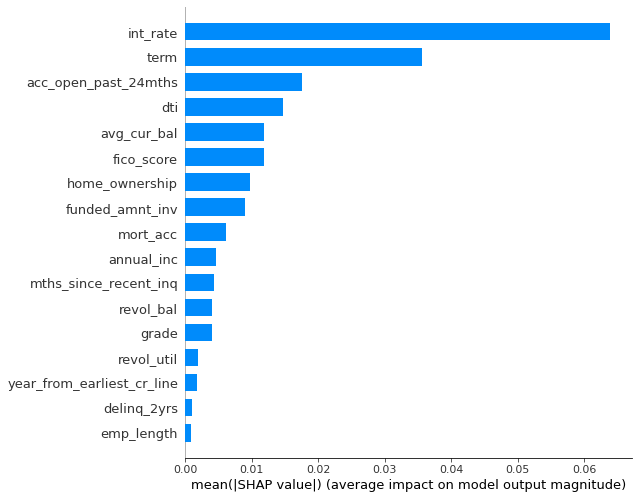

In [36]:
shap.summary_plot(shap_values, plot_type='bar', features=X_test_display)

**Summary Shap Plot**  

- Summary shap plot uses a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. 
- Features are sorted by the sum of the SHAP value magnitudes across all samples.

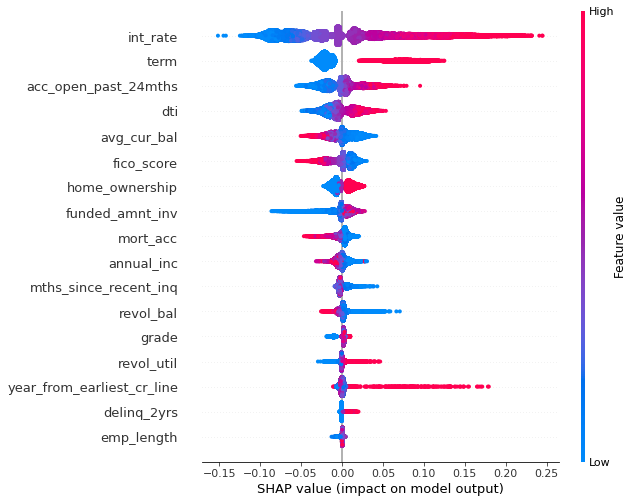

In [37]:
shap.summary_plot(shap_values,features= X_test, feature_names=X_test_display.columns )

Here, we see as expected higher values for the interest rate increases the shap values that shows high probability for positive label, which is being default. One thing we also notice is that although 'year_from_earliest_cr_line' has low importance, for some samples it effects by a large amount(shap values.)

**Shap Dependence Plot**  

SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature’s value vs. the SHAP value of that feature across many samples.

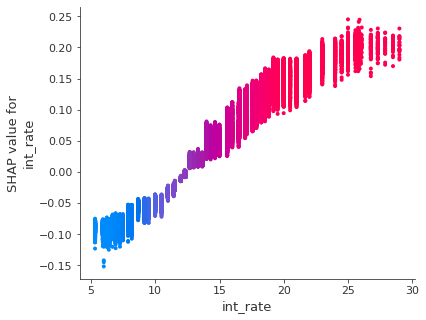

In [38]:
# shap dependence plot for interest rate
shap.dependence_plot('int_rate', shap_values, features=X_test, interaction_index='int_rate')

Again here we see the relation that higher interest rates have high shap values and low interest rates are related with lower shap values.

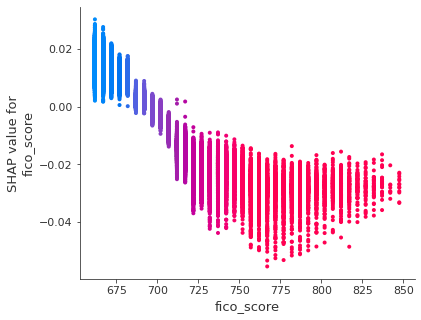

In [39]:
# shap dependence plot for fico score
shap.dependence_plot('fico_score', shap_values, features=X_test, interaction_index='fico_score')

Higher fico score have low shap values, while low fico scores have high shap values contributing in probability of default.

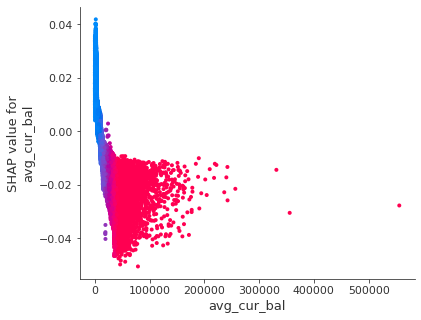

In [40]:
# shap dependence plot for avg_cur_bal
shap.dependence_plot('avg_cur_bal', shap_values, features=X_test, interaction_index='avg_cur_bal')

Shap dependence plot also allows to see interaction between two features. We can explicitly set the feature to see the interaction. If we set it as 'auto', then it will use the feature that seems to have the strongest interaction.


The index of the feature used to color the plot. The name of a feature can also be passed
    as a string. If "auto" then shap.common.approximate_interactions is used to pick what
    seems to be the strongest interaction (note that to find to true stongest interaction you
    need to compute the SHAP interaction values).

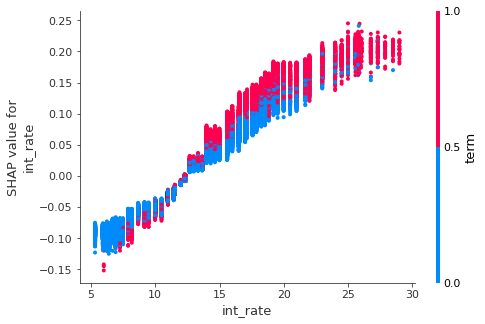

In [41]:
# shap depedence plot of interest rate with interaction
shap.dependence_plot('int_rate', shap_values, features=X_test, interaction_index='auto')

Here, we see the interaction between interest rate and term. Higher interest rate and high loan term are seen to have more impact than samples with low interest rate and low term period.

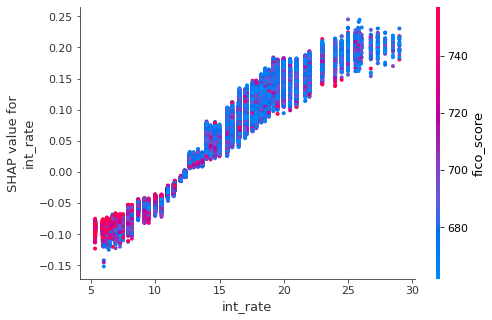

In [42]:
# shap depedence plot of interest rate with interaction with fico score
shap.dependence_plot('int_rate', shap_values, features=X_test, interaction_index='fico_score')

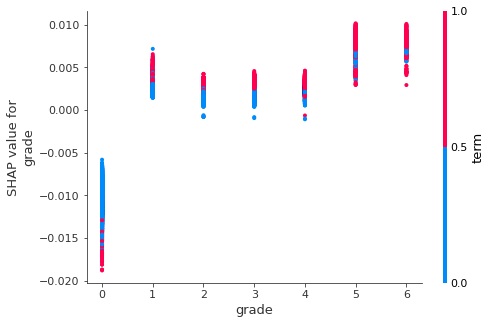

In [43]:
# shap depedence plot of grade with interaction 
shap.dependence_plot('grade', shap_values, features=X_test,  interaction_index='auto')

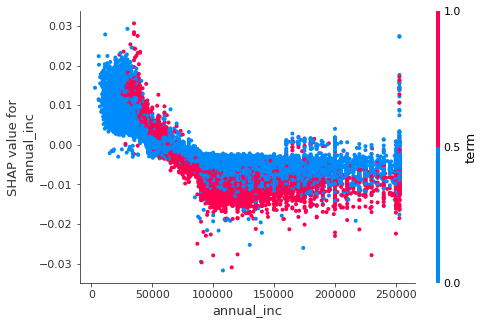

In [44]:
# shap depedence plot of annual income with interaction 
shap.dependence_plot('annual_inc', shap_values, features=X_test,  interaction_index='auto')

####Explaining Individual Predictions

**Force Plot**

In [45]:
shap.initjs()
shap.force_plot(base_value=explainer.expected_value, shap_values=shap_values[4,:], features=X_test_display.iloc[4,:])

The force plot impact of each features in the final prediction and in which direction.

The effect of features in the overall outcome for a single sample can also be visualise with waterfall plot. 

**Waterfall Plot**

In [49]:
explainer_waterfall = shap.TreeExplainer(xgb, data= X_train,  model_output="probability")

In [50]:
shap_values_waterfall = explainer_waterfall(X_test)

100%|===================| 79744/79811 [02:05<00:00]       

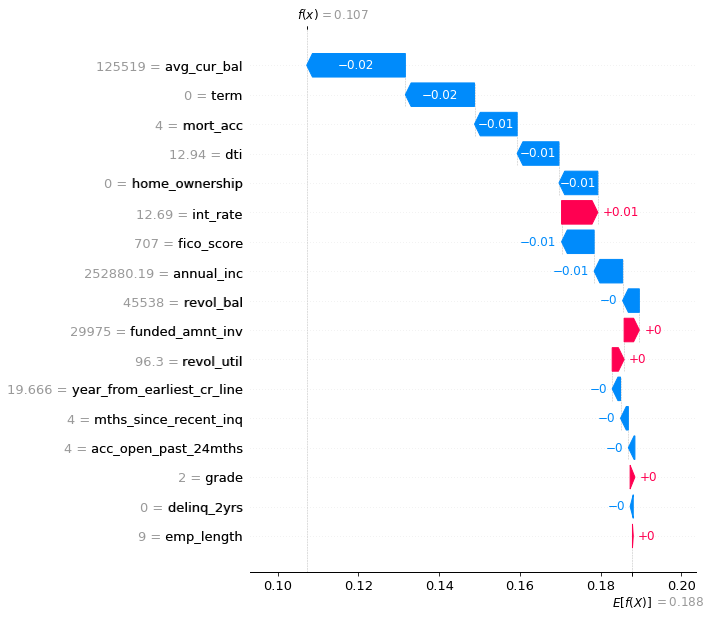

In [51]:
shap.plots.waterfall(shap_values=shap_values_waterfall[4], max_display=20)

The bottom of a waterfall plot starts as the expected value of the model output, and then each row shows how the positive (red) or negative (blue) contribution of each feature moves the value from the expected model output over the background dataset to the model output for this prediction.

Instead of showing all the features, we can also show the top impacting features for the sample. The features with low impact will be grouped into a single feature as 'other features'

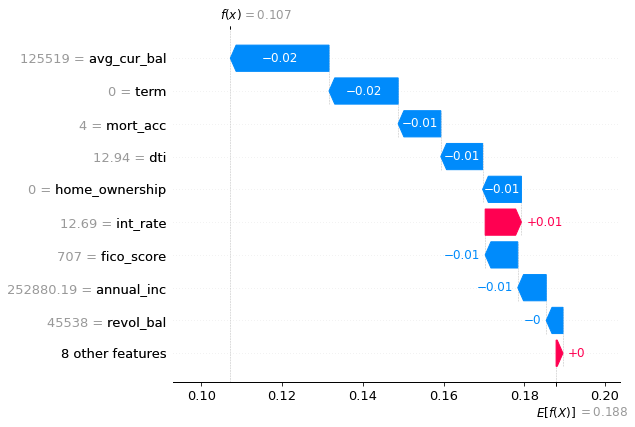

In [52]:
shap.plots.waterfall(shap_values_waterfall[4], max_display=10)